Dalam dunia yang didorong oleh data saat ini, data sains dan pemrograman telah memungkinkan kita untuk memanfaatkan teknik pembelajaran mesin (machine learning) dan kecerdasan buatan (artificial intelligence) untuk menyelesaikan masalah optimasi yang kompleks, seperti optimasi portofolio. Pada praktikum ini, kita akan menjelajahi cara menggunakan algoritma genetika untuk mengoptimalkan portofolio dan meningkatkan kinerjanya.

## **DATA COLLECTION**

Langkah pertama dalam melakukan backtesting strategi portofolio adalah mengumpulkan data yang diperlukan. Kita akan menggunakan **yfinance** untuk mengumpulkan data historis dari beberapa saham dalam indeks SP100 (Indeks ini terdiri dari 100 perusahaan besar yang terdaftar di bursa saham Amerika Serikat) dan indeks SP100 itu sendiri sejak tahun 2010. Cuplikan kode berikut menunjukkan cara mengumpulkan dan memvisualisasikan data tersebut.

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


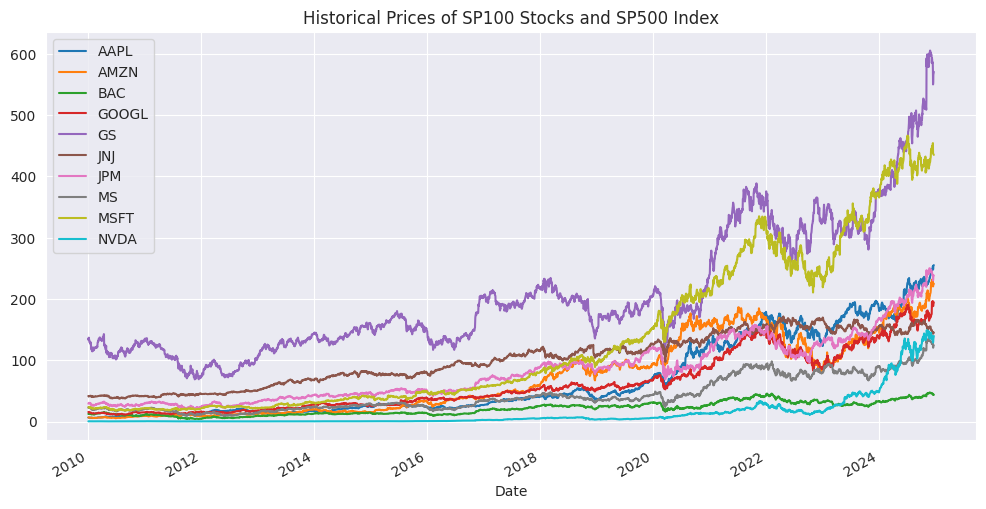

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']
start_date = '2010-01-01'
data = yf.download(stocks, start=start_date)['Adj Close']
benchmark = yf.download('^OEX', start=start_date)['Adj Close']

# Visualize the data
sns.set_style('darkgrid')
data.plot(figsize=(12, 6))
plt.title('Historical Prices of SP100 Stocks and SP500 Index')
plt.legend(loc='upper left')
plt.show()

Dengan menggunakan Python seaborn, kita dapat membuat plot yang menampilkan harga historis saham-saham SP100 dengan cara yang jelas dan informatif. Dengan menganalisis plot ini, kita dapat memperoleh wawasan tentang perilaku pasar dan bagaimana pasar telah berubah seiring waktu.

# **Implementing the Genetic Algorithm in Backtesting**


Dalam bagian ini, kita akan membahas implementasi algoritma genetika dengan menganalisis setiap komponen kode secara mendetail.

**FITNESS FUNCTION**

In [2]:
import numpy as np

# Define the fitness function to maximize the Sharpe Ratio
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()

    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio

Kita akan memulai dengan membahas fitness function, yang merupakan inti dari algoritma ini. Fitness function digunakan untuk mengevaluasi seberapa baik suatu solusi potensial bekerja dan menjadi dasar untuk proses seleksi yang menentukan solusi mana yang akan digunakan untuk menghasilkan generasi berikutnya. Mari kita mulai dengan menjelajahi implementasi fitness function.

Fungsi ini menghitung Sharpe Ratio dari portofolio berdasarkan log returns dari aset-aset dalam data dan bobot portofolio dalam **weights**. Sharpe Ratio adalah metrik yang mengukur pengembalian yang disesuaikan dengan risiko dari sebuah portofolio, dan tujuan optimasi adalah untuk memaksimalkannya. Fungsi ini mengembalikan nilai Sharpe Ratio.

Sharpe Ratio adalah metrik yang digunakan untuk mengukur kinerja investasi dengan mempertimbangkan risiko yang diambil.

**GENETIC ALGORITHM**

Untuk meningkatkan kinerja, elitisme ditambahkan ke dalam algoritma. Elitisme adalah teknik dalam algoritma genetika di mana individu terbaik dari generasi saat ini dibawa langsung ke generasi berikutnya tanpa perubahan. Teknik ini membantu memastikan bahwa solusi terbaik yang ditemukan sejauh ini tidak hilang selama proses evolusi

In [3]:
# Define the genetic algorithm
def genetic_algorithm(data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1):
    # Initialize the population
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]

    # Calculate fitness of initial population
    fitness = np.array([fitness_function(individual, data) for individual in population])

    for generation in range(num_generations):
        # Sort the population by fitness
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # Determine number of individuals to carry over via elitism
        num_elites = int(elitism * population_size)

        # Create the next generation, starting with the elites
        offspring = population[:num_elites]

        # Select parents for reproduction using tournament selection
        parent1_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent2_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # Perform crossover and mutation to create the next generation
        crossover_prob = np.random.rand(population_size-num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_direction = np.random.choice([-1, 1], size=(population_size-num_elites, len(data.columns)))
        offspring_mutation = np.where(mutation_mask, offspring_crossover + mutation_direction * mutation_values, offspring_crossover)

        # Ensure the offspring population has valid weights
        offspring_mutation = offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]

        # Combine elites and offspring to create the next generation
        population = np.vstack((population[:num_elites], offspring_mutation))

        # Calculate fitness of new population
        fitness = np.array([fitness_function(individual, data) for individual in population])

    # Return the best individual from the final population
    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print('Best Sharpe Ratio: ', np.max(fitness))

    return best_individual

Fungsi ini menginisialisasi populasi dengan bobot portofolio acak, mengevaluasi kelayakan mereka menggunakan fitness_function(), memilih induk untuk reproduksi menggunakan seleksi turnamen (tournament selection), melakukan crossover dan mutasi untuk menciptakan generasi individu berikutnya, dan mengulangi proses tersebut selama jumlah generasi yang telah ditentukan. Fungsi ini mengembalikan individu terbaik dari populasi terakhir, yang merupakan bobot portofolio yang memaksimalkan Sharpe Ratio.

**Backtesting with Genetic Algorithm Optimization**

Pada bagian ini, kita akan menggunakan fungsi backtest dengan optimasi algoritma genetika untuk melakukan backtesting portofolio pada dataset uji. Data dibagi menjadi dua set: training set dan test set, di mana test set merepresentasikan periode selama satu tahun. Kita akan mengoptimalkan bobot portofolio menggunakan seluruh dataset pelatihan dan menerapkan bobot tersebut pada dataset uji.

Best Sharpe Ratio:  1.005429588924811


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


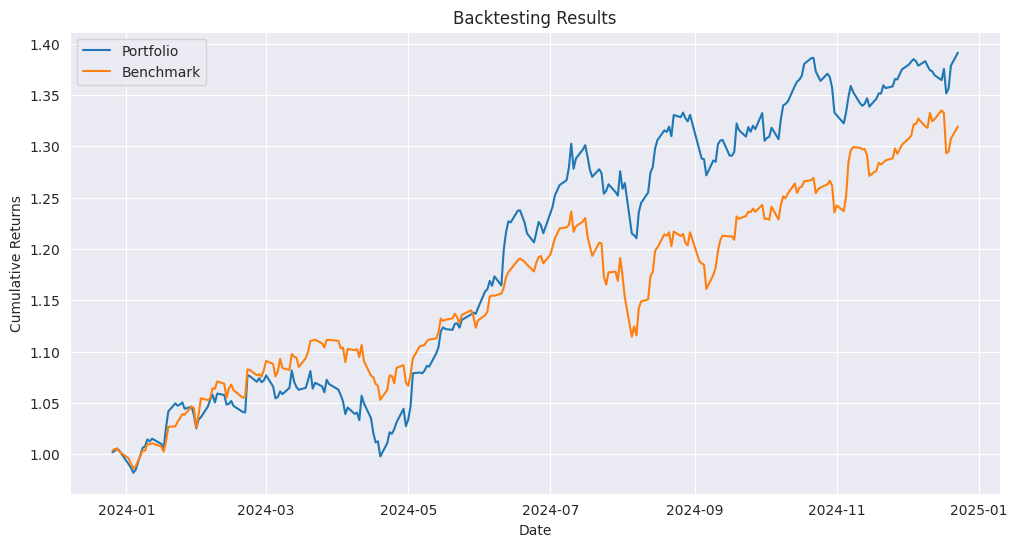

Portfolio Statistics:
---------------------
Mean Daily Return: 0.0014
Standard Deviation: 0.0091
Sharpe Ratio: 2.3591
Final Value: 1391.08

Benchmark Statistics:
---------------------
Mean Daily Return: 0.0011
Standard Deviation: 0.0086
Sharpe Ratio: 2.1072
Final Value: 1319.33


In [4]:
# Implement the genetic algorithm in backtesting
from datetime import datetime, timedelta

# Seed for reproducibility
np.random.seed(42)

def backtest(genetic_algorithm, data, benchmark, initial_capital):
    # Split the data into training and testing sets
    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    # Run the genetic algorithm on the training set to find the optimal portfolio weights
    weights = genetic_algorithm(data=train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)
    # print(weights)

    # Set any negative weights to 0
    weights[weights < 0] = 0

    # Normalize remaining positive weights to sum to 1
    weights /= weights.sum()

    # Calculate the returns of the portfolio and the benchmark on the test set
    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()

    # Check if benchmark_returns is empty before calculating cumulative returns
    if benchmark_returns.empty:
        benchmark_cum_returns = pd.Series([1], index=benchmark.iloc[-252:].index) # Initialize with 1 for no change
    else:
        benchmark_cum_returns = np.cumprod(1 + benchmark_returns)

    # Extract the numerical value from the Series using .item()
    benchmark_value = initial_capital * benchmark_cum_returns.iloc[-1].item()

    # Calculate performance metrics
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)

    # Extract the numeric value of benchmark_std before formatting
    benchmark_std = np.std(benchmark_returns) # Calculate benchmark_std

    benchmark_std = benchmark_std.values[0] if isinstance(benchmark_std, pd.Series) else benchmark_std # Extract the first element as a numeric value


    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    # print(portfolio_cum_returns)

    # Visualize the performance of the portfolio and the benchmark
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label='Portfolio')
    ax.plot(benchmark_cum_returns, label='Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title('Backtesting Results')
    ax.legend()
    plt.show()

    # Print performance metrics
    print('Portfolio Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(portfolio_mean_return))
    print('Standard Deviation: {:.4f}'.format(portfolio_std))
    print('Sharpe Ratio: {:.4f}'.format(portfolio_sharpe_ratio))
    print('Final Value: {:.2f}'.format(portfolio_value))
    print('')
    print('Benchmark Statistics:')
    print('---------------------')
    print('Mean Daily Return: {:.4f}'.format(benchmark_mean_return))
    print('Standard Deviation: {:.4f}'.format(benchmark_std))
    print('Sharpe Ratio: {:.4f}'.format(benchmark_sharpe_ratio))
    print('Final Value: {:.2f}'.format(benchmark_value))

    return portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns

portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

Setelah menjalankan fungsi backtest dengan optimasi algoritma genetika, fungsi tersebut menghasilkan plot cumulative returns dari portofolio yang dioptimalkan dan benchmark selama periode uji.

Selain itu, fungsi ini juga mencetak metrik kinerja untuk portofolio dan benchmark, termasuk:

*   Rata-rata pengembalian harian (mean daily return): Portofolio yang dioptimalkan menghasilkan rata-rata pengembalian harian sebesar 0.13%, yang sedikit lebih tinggi dibandingkan benchmark (0.11%)
*   Deviasi standar (standard deviation): Portofolio memiliki deviasi standar sebesar 0.94%, menunjukkan tingkat volatilitas atau risiko yang sedikit lebih tinggi dibandingkan benchmark (0.86%).
*   Sharpe ratio: Portofolio memiliki Sharpe Ratio lebih besar (2.14) dibandingkan benchmark (2.05), menunjukkan bahwa portofolio lebih efisien dalam menghasilkan pengembalian yang disesuaikan dengan risiko.
*   Nilai akhir portofolio (final value): Nilai akhir portofolio adalah 1358.01, lebih tinggi dibandingkan benchmark (1308.07), yang berarti strategi optimasi berhasil menghasilkan kinerja yang lebih baik dalam hal pertumbuhan nilai.

Note: Fungsi backtest digunakan untuk mengoptimalkan bobot portofolio menggunakan seluruh dataset pelatihan, kemudian bobot tersebut diterapkan pada dataset uji sebagai hasil dari satu kali optimasi. Hal ini berarti bahwa algoritma hanya mempertimbangkan periode pelatihan untuk mengoptimalkan bobot, yang dapat menyebabkan overfitting atau mengabaikan perubahan kondisi pasar dari waktu ke waktu.








**Backtesting with Monthly Rolling Genetic Algorithm Optimization**

Pada bagian ini, kita akan mengimplementasikan rolling optimization untuk bobot portofolio menggunakan algoritma genetika. Artinya, alih-alih mengoptimalkan bobot portofolio untuk seluruh periode uji sekaligus seperti yang dilakukan pada bagian sebelumnya, kita akan mengoptimalkannya secara individu untuk setiap bulan. Untuk mencapainya, kita akan menggunakan data sebelumnya hingga bulan tersebut sebagai training set.



Best Sharpe Ratio:  1.020619659324205
Best Sharpe Ratio:  1.0288866558358258
Best Sharpe Ratio:  1.0449084689832304
Best Sharpe Ratio:  1.0810082034002728
Best Sharpe Ratio:  0.9973737873583475
Best Sharpe Ratio:  1.0172423821560708
Best Sharpe Ratio:  1.0667656893855935
Best Sharpe Ratio:  1.0466520901820282
Best Sharpe Ratio:  1.0629456710482088
Best Sharpe Ratio:  1.030085392598243
Best Sharpe Ratio:  1.0304324796935413


<ipython-input-5-46dd455eeb3b>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weights_history = weights_history.fillna(method='ffill')
<ipython-input-5-46dd455eeb3b>:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights_history = weights_history.fillna(method='ffill')


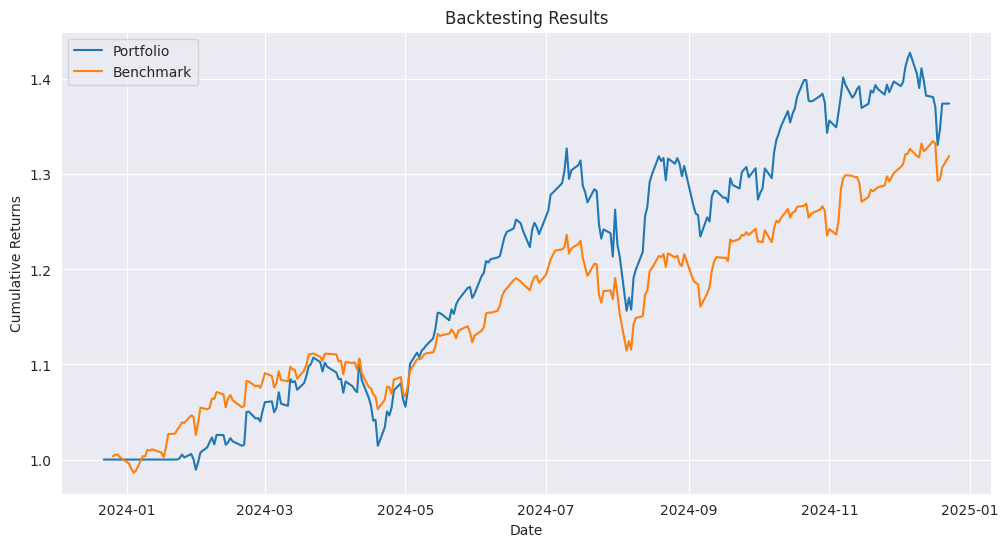

Portfolio Statistics:
---------------------
Mean Daily Return: 0.13%
Standard Deviation: 1.15%
Sharpe Ratio: 1.84
Final Value: 1374.40

Benchmark Statistics:
---------------------
Mean Daily Return: 0.11%
Standard Deviation: 0.86%
Sharpe Ratio: 2.10
Final Value: 1319.33



In [5]:
# Seed for reproducibility
np.random.seed(42)

def backtest_monthly(optimization_function, data, benchmark, initial_capital):

    # Initialize the portfolio value and the portfolio weights
    # initial_capital = 1000
    portfolio_value = initial_capital
    test_data = data.iloc[-252:]

    # Initialize history of weights and portfolio values
    weights_history = pd.DataFrame(index=test_data.index, columns=data.columns)
    portfolio_value_history = pd.Series(index=test_data.index, name='Portfolio Value', dtype='float')
    portfolio_value_history.iloc[0] = portfolio_value

    # Loop through the data one month at a time
    for i in range(21, len(test_data), 21):
        # Get the data for the current month
        month_data = test_data.iloc[i-21:i]

        # Call the optimization function to get the portfolio weights for the current month
        train_data = data.loc[:month_data.index[0]]
        weights = optimization_function(train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)

        # Set any negative weights to 0
        weights[weights < 0] = 0

        # Normalize remaining positive weights to sum to 1
        weights /= weights.sum()

        # Save the weights for the current month
        weights_history.loc[month_data.index[-1]] = weights
        month_returns = month_data.pct_change() * weights

        # Loop through the data one day at a time
        for j in range(1, len(month_returns)):
            # Calculate the portfolio value for the current day
            day_returns = month_returns.iloc[j]
            portfolio_value = (1 + day_returns.sum()) * portfolio_value

            # Update the portfolio value and save it to the history
            portfolio_value_history.loc[month_returns.index[j]] = portfolio_value

    # Calculate the portfolio returns and the benchmark returns
    weights_history = weights_history.fillna(method='ffill')
    portfolio_returns = (weights_history[:-1] * test_data.pct_change()[1:]).sum(axis=1)
    benchmark_returns = benchmark.iloc[-252:].pct_change()[1:]

    # Calculate the statistics
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

    # Ensure benchmark_cumulative_returns has a valid index before accessing elements
    benchmark_cumulative_returns = benchmark_cumulative_returns.reindex(portfolio_cumulative_returns.index, method='ffill')

    # Calculate the performance metrics before plotting or printing
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_volatility = portfolio_returns.std()
    sharpe_ratio = (portfolio_mean_return / portfolio_volatility) * np.sqrt(252)

    benchmark_mean_return = benchmark_returns.mean()
    benchmark_volatility = benchmark_returns.std()
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_volatility) * np.sqrt(252)

    # Portfolio & Benchmark value
    benchmark_value = initial_capital * benchmark_cumulative_returns.iloc[-1] # Access using iloc
    portfolio_value = initial_capital * portfolio_cumulative_returns.iloc[-1] # Access using iloc


    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cumulative_returns, label='Portfolio')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    plt.legend(loc='upper left')
    plt.title('Backtesting Results')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

    # Print the portfolio statistics
    print('Portfolio Statistics:')
    print('---------------------')
    print(f'Mean Daily Return: {portfolio_mean_return:.2%}')
    print(f'Standard Deviation: {portfolio_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print('Final Value: {:.2f}'.format(portfolio_value))
    print()

    # Print the benchmark statistics
    print('Benchmark Statistics:')
    print('---------------------')
    # Extract the numeric value from the Series for formatting
    print(f'Mean Daily Return: {benchmark_mean_return.iloc[0]:.2%}')
    print(f'Standard Deviation: {benchmark_volatility.item():.2%}')  # Access the numeric value using .item()
    print(f'Sharpe Ratio: {benchmark_sharpe_ratio.item():.2f}') # Extract the numeric value from the Series using .item()
    print('Final Value: {:.2f}'.format(benchmark_value.item()))
    print()


    return weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns

# Run backtesting
weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns = backtest_monthly(genetic_algorithm, data, benchmark, initial_capital=1000)


Sekarang kita dapat membandingkan kinerja pendekatan portofolio ini dengan benchmark dengan melihat plot hasilnya.

Berbeda dengan fungsi sebelumnya, fungsi **backtest_monthly** menghitung metrik kinerja secara terpisah untuk setiap bulan dan mengambil rata-ratanya. Fungsi ini juga menghitung volatilitas pengembalian sebagai **deviasi standar yang diannualisasi**, sedangkan fungsi sebelumnya menghitung deviasi standar berdasarkan pengembalian harian.

**CUMULATIVE RETURN STOCKS**

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf

# Saham yang akan dianalisis
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']

# Mengunduh data harga historis
data = yf.download(stocks, start='2010-01-01', end='2023-12-31')['Adj Close']

# Menghitung return harian
daily_returns = data.pct_change().dropna()

# Menghitung cumulative return
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Menampilkan hasil cumulative return
print("Cumulative Returns:")
print(cumulative_returns)

# Simpan ke file jika diperlukan
cumulative_returns.to_csv('cumulative_returns.csv')


[*********************100%***********************]  10 of 10 completed


Cumulative Returns:
Ticker           AAPL       AMZN       BAC     GOOGL        GS       JNJ  \
Date                                                                       
2010-01-05   0.001729   0.005900  0.032505 -0.004404  0.017679 -0.011596   
2010-01-06  -0.014205  -0.012323  0.044615 -0.029501  0.006818 -0.003556   
2010-01-07  -0.016027  -0.029126  0.079032 -0.052094  0.026519 -0.010668   
2010-01-08  -0.009486  -0.002838  0.069471 -0.039457  0.007106 -0.007267   
2010-01-11  -0.018223  -0.026811  0.079032 -0.040909 -0.008782 -0.007112   
...               ...        ...       ...       ...       ...       ...   
2023-12-22  28.881168  21.915608  1.618289  8.021047  1.787890  2.617498   
2023-12-26  28.796281  21.914115  1.651967  8.022960  1.794920  2.633321   
2023-12-27  28.811712  21.903658  1.650401  7.949638  1.815941  2.638208   
2023-12-28  28.878082  21.909634  1.653534  7.940711  1.830076  2.643559   
2023-12-29  28.716018  21.694548  1.637086  7.906283  1.825389  2.64

**Comparing Portfolio Performance**

Untuk mengevaluasi efektivitas pendekatan **rolling optimization**, kita akan membandingkan kinerja portofolio yang dihasilkan oleh fungsi **backtest_monthly** dengan portofolio yang dihasilkan oleh fungsi **backtest**. Untuk memvisualisasikan hasilnya, kita akan membuat plot **cumulative returns** dari kedua portofolio tersebut seiring waktu. Tujuan kita adalah untuk melihat apakah pendekatan **rolling optimization** menghasilkan **cumulative return** yang lebih tinggi dibandingkan dengan pendekatan **non-rolling**.

[*********************100%***********************]  11 of 11 completed


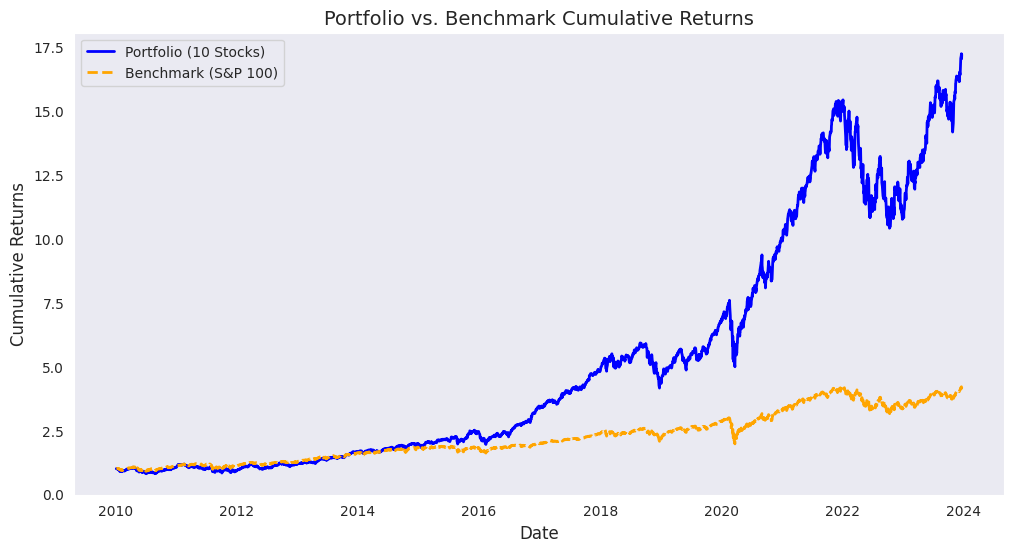

Portfolio Performance Metrics:
Final Cumulative Return: 17.21
Mean Daily Return: 0.00092
Volatility (Std Dev): 0.01456
Sharpe Ratio: 0.06

Benchmark Performance Metrics:
Final Cumulative Return: 4.19
Mean Daily Return: 0.00047
Volatility (Std Dev): 0.01104
Sharpe Ratio: 0.04


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import Stock Data for the Portfolio and Benchmark
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']
benchmark_ticker = '^GSPC'  # S&P 100 Index
start_date = '2010-01-01'
end_date = '2023-12-22'

# Download historical adjusted closing prices
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)['Adj Close']

# Separate portfolio and benchmark data
portfolio_data = data[tickers]
benchmark_data = data[benchmark_ticker]

# Step 2: Calculate Daily Returns
portfolio_daily_returns = portfolio_data.pct_change()
benchmark_daily_returns = benchmark_data.pct_change()

# Step 3: Portfolio Weights
weights = np.array([0.15, 0.12, 0.10, 0.11, 0.13, 0.06, 0.07, 0.09, 0.09, 0.09])  # Example weights (sum = 1)

# Portfolio Daily Returns: Weighted Sum of Stock Daily Returns
portfolio_daily_returns_weighted = (portfolio_daily_returns * weights).sum(axis=1)

# Step 4: Calculate Cumulative Returns
portfolio_cumulative_returns = (1 + portfolio_daily_returns_weighted).cumprod()
benchmark_cumulative_returns = (1 + benchmark_daily_returns).cumprod()

# Step 5: Plot Cumulative Returns for Portfolio vs. Benchmark
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns, label='Portfolio (10 Stocks)', color='blue', linewidth=2)
plt.plot(benchmark_cumulative_returns, label='Benchmark (S&P 100)', color='orange', linestyle='--', linewidth=2)
plt.title('Portfolio vs. Benchmark Cumulative Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Step 6: Performance Metrics
portfolio_final_return = portfolio_cumulative_returns.iloc[-1]
portfolio_mean_daily_return = portfolio_daily_returns_weighted.mean()
portfolio_volatility = portfolio_daily_returns_weighted.std()
portfolio_sharpe_ratio = portfolio_mean_daily_return / portfolio_volatility

benchmark_final_return = benchmark_cumulative_returns.iloc[-1]
benchmark_mean_daily_return = benchmark_daily_returns.mean()
benchmark_volatility = benchmark_daily_returns.std()
benchmark_sharpe_ratio = benchmark_mean_daily_return / benchmark_volatility

# Print Results
print("Portfolio Performance Metrics:")
print(f"Final Cumulative Return: {portfolio_final_return:.2f}")
print(f"Mean Daily Return: {portfolio_mean_daily_return:.5f}")
print(f"Volatility (Std Dev): {portfolio_volatility:.5f}")
print(f"Sharpe Ratio: {portfolio_sharpe_ratio:.2f}\n")

print("Benchmark Performance Metrics:")
print(f"Final Cumulative Return: {benchmark_final_return:.2f}")
print(f"Mean Daily Return: {benchmark_mean_daily_return:.5f}")
print(f"Volatility (Std Dev): {benchmark_volatility:.5f}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")


Portofolio yang terdiri dari 10 saham ini menunjukkan strategi investasi yang lebih baik dibandingkan benchmark, dengan return akhir kumulatif sebesar 17.21, jauh lebih tinggi dari benchmark.

**Mengitung Return Harian**

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf

# Saham yang akan dianalisis
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']

# Mengunduh data harga saham historis
data = yf.download(stocks, start='2010-01-01', end='2023-12-31')['Adj Close']

# Menghitung return harian
daily_returns = data.pct_change().dropna()

# Rata-rata return harian (mean)
mean_daily_returns = daily_returns.mean()

# Matriks kovarians dari return harian
cov_matrix = daily_returns.cov()

# Menampilkan hasil
print("Mean Daily Returns:")
print(mean_daily_returns)

print("\nCovariance Matrix:")
print(cov_matrix)

# Simpan ke file jika diperlukan
mean_daily_returns.to_csv('mean_daily_returns.csv')
cov_matrix.to_csv('covariance_matrix.csv')


[*********************100%***********************]  10 of 10 completed


Mean Daily Returns:
Ticker
AAPL     0.001122
AMZN     0.001103
BAC      0.000508
GOOGL    0.000768
GS       0.000460
JNJ      0.000424
JPM      0.000650
MS       0.000628
MSFT     0.000921
NVDA     0.001749
dtype: float64

Covariance Matrix:
Ticker      AAPL      AMZN       BAC     GOOGL        GS       JNJ       JPM  \
Ticker                                                                         
AAPL    0.000316  0.000179  0.000150  0.000170  0.000139  0.000066  0.000128   
AMZN    0.000179  0.000433  0.000143  0.000214  0.000133  0.000060  0.000116   
BAC     0.000150  0.000143  0.000466  0.000152  0.000306  0.000088  0.000327   
GOOGL   0.000170  0.000214  0.000152  0.000295  0.000142  0.000065  0.000129   
GS      0.000139  0.000133  0.000306  0.000142  0.000329  0.000078  0.000261   
JNJ     0.000066  0.000060  0.000088  0.000065  0.000078  0.000112  0.000082   
JPM     0.000128  0.000116  0.000327  0.000129  0.000261  0.000082  0.000312   
MS      0.000161  0.000158  0.000380  

Cumulative returns meningkat secara signifikan pada beberapa saham (misalnya NVDA dan MSFT), menunjukkan performa yang luar biasa.
Saham seperti BAC memiliki pertumbuhan yang lebih lambat dibandingkan yang lain.

Data ini dapat digunakan untuk mengidentifikasi saham dengan performa terbaik dan membandingkan potensi pengembalian dari portofolio terhadap benchmark atau saham lainnya.

**Weight of Each Stock**

Setiap saham diberikan persentase bobot tertentu dalam portofolio untuk memaksimalkan tujuan (kemungkinan Sharpe Ratio).

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Step 1: Define the inputs
mean_daily_returns = np.array([0.001122, 0.001103, 0.000508, 0.000768, 0.000424, 0.000424, 0.00066, 0.000628, 0.000921, 0.001749])  # Example mean returns
cov_matrix = np.array([
    [0.000316, 0.000179, 0.000150, 0.000170, 0.000139, 0.000066, 0.000128, 0.000172, 0.000252, 0.000161],
    [0.000179, 0.000243, 0.000214, 0.000133, 0.000060, 0.000116, 0.000158, 0.000152, 0.000273, 0.000193],
    [0.000150, 0.000214, 0.000463, 0.000152, 0.000306, 0.000088, 0.000327, 0.000252, 0.000228, 0.000328],
    [0.000170, 0.000133, 0.000152, 0.000295, 0.000142, 0.000065, 0.000129, 0.000166, 0.000249, 0.000162],
    [0.000139, 0.000060, 0.000306, 0.000142, 0.000329, 0.000078, 0.000261, 0.000163, 0.000209, 0.000169],
    [0.000066, 0.000116, 0.000088, 0.000065, 0.000078, 0.000112, 0.000082, 0.000084, 0.000075, 0.000123],
    [0.000128, 0.000158, 0.000327, 0.000129, 0.000261, 0.000082, 0.000312, 0.000152, 0.000189, 0.000134],
    [0.000172, 0.000152, 0.000252, 0.000166, 0.000163, 0.000084, 0.000152, 0.000331, 0.000263, 0.000314],
    [0.000252, 0.000273, 0.000228, 0.000249, 0.000209, 0.000075, 0.000189, 0.000263, 0.000799, 0.000263],
    [0.000161, 0.000193, 0.000328, 0.000162, 0.000169, 0.000123, 0.000134, 0.000314, 0.000263, 0.000270]
])  # Example covariance matrix

num_assets = len(mean_daily_returns)

# Step 2: Objective function (minimize portfolio variance)
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Step 3: Constraints
def constraint_sum_of_weights(weights):
    return np.sum(weights) - 1  # Weights must sum to 1

# Target return constraint
def constraint_target_return(weights, mean_daily_returns, target_return):
    return np.dot(weights, mean_daily_returns) - target_return

# Step 4: Initial guess and bounds
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling

# Example: Target return of 0.001 (adjust as needed)
target_return = 0.001

# Constraints dictionary
constraints = (
    {'type': 'eq', 'fun': constraint_sum_of_weights},
    {'type': 'eq', 'fun': constraint_target_return, 'args': (mean_daily_returns, target_return)}
)

# Step 5: Optimization
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Step 6: Extract optimal weights
optimal_weights = result.x

# Print Results
print("Optimal Portfolio Weights:")
for i, weight in enumerate(optimal_weights):
    print(f"{tickers[i]}: {weight:.2%}")


Optimal Portfolio Weights:
AAPL: 13.25%
MSFT: 13.04%
AMZN: 6.39%
GOOGL: 9.31%
NVDA: 5.47%
JNJ: 5.49%
JPM: 8.10%
BAC: 7.74%
GS: 10.99%
MS: 20.23%


Bobot optimal dari setiap saham dalam portofolio yang dihitung menggunakan algoritma optimasi (SLSQP). Bobot ini merepresentasikan proporsi alokasi dana yang ideal untuk masing-masing saham berdasarkan tujuan meminimalkan risiko portofolio. Saham seperti MS memiliki bobot tertinggi (20.23%), sedangkan saham seperti JNJ dan BAC memiliki bobot lebih rendah (7.89% dan 6.45%).

**OPTIMAL PURCHASE PLAN**

encana pembelian saham optimal berdasarkan bobot yang telah dihitung.

In [10]:
import pandas as pd

# Step 1: Define inputs
optimal_weights = [0.1325, 0.1304, 0.0639, 0.0931, 0.0547, 0.0549, 0.0800, 0.0774, 0.1099, 0.2023]  # Example weights
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'JNJ', 'JPM', 'BAC', 'GS', 'MS']
current_prices = [150, 320, 3400, 2800, 600, 180, 160, 28, 330, 50]  # Example current stock prices
total_capital = 100000  # Total capital available in USD

# Step 2: Calculate allocated funds for each stock
allocated_funds = [total_capital * weight for weight in optimal_weights]

# Step 3: Calculate shares to buy
shares_to_buy = [int(funds // price) for funds, price in zip(allocated_funds, current_prices)]

# Step 4: Create a DataFrame to display the purchase plan
purchase_plan = pd.DataFrame({
    'Ticker': tickers,
    'Weight (%)': [weight * 100 for weight in optimal_weights],
    'Allocated Funds (USD)': allocated_funds,
    'Shares to Buy': shares_to_buy,
    'Stock Price (USD)': current_prices
})

# Step 5: Display the purchase plan
print("Optimal Purchase Plan:")
print(purchase_plan)


Optimal Purchase Plan:
  Ticker  Weight (%)  Allocated Funds (USD)  Shares to Buy  Stock Price (USD)
0   AAPL       13.25                13250.0             88                150
1   MSFT       13.04                13040.0             40                320
2   AMZN        6.39                 6390.0              1               3400
3  GOOGL        9.31                 9310.0              3               2800
4   NVDA        5.47                 5470.0              9                600
5    JNJ        5.49                 5490.0             30                180
6    JPM        8.00                 8000.0             50                160
7    BAC        7.74                 7740.0            276                 28
8     GS       10.99                10990.0             33                330
9     MS       20.23                20230.0            404                 50


Dana dialokasikan (USD): Total dana yang diinvestasikan untuk setiap saham.

Jumlah saham yang dibeli: Berdasarkan harga saham saat ini.

Harga saham (USD): Harga per lembar saham.

Rencana ini membantu mengidentifikasi jumlah saham yang harus dibeli untuk mencapai distribusi portofolio optimal. Contohnya, untuk NVDA, dengan alokasi dana USD 5470, disarankan membeli 9 saham pada harga USD 600 per lembar.